8792
8968


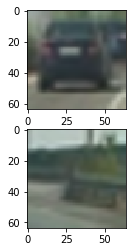

In [1]:
%matplotlib inline
import os
import cv2
from matplotlib import pyplot as plt


def load_images(dir):
    rv = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for fn in sorted(filenames):
            if fn.endswith('.png'):
                imdata = cv2.imread(os.path.join(dirpath, fn))
                imdata = cv2.cvtColor(imdata, cv2.COLOR_BGR2RGB)
                rv.append(imdata)
    
    return rv


vehicles_unshuffled = load_images('vehicles')
non_vehicles_unshuffled = load_images('non-vehicles')

print(len(vehicles_unshuffled))
print(len(non_vehicles_unshuffled))
_, (ax1, ax2) = plt.subplots(2)
ax1.imshow(vehicles_unshuffled[0])
ax2.imshow(non_vehicles_unshuffled[1])

In [2]:
import itertools
import random


def block_shuffle(l, block_size, random=random):
    blocks = list(itertools.zip_longest(*[iter(l)]*block_size))
    blocks[-1] = [im for im in blocks[-1] if im is not None]
    random.shuffle(blocks)
    return list(itertools.chain.from_iterable(blocks))

# in GTI dataset, vehicles typically appear for up to 15 frames. So, we do a block shuffle with block size
# 15.
vehicles_shuffled = block_shuffle(vehicles_unshuffled, 15)
non_vehicles_shuffled = block_shuffle(non_vehicles_unshuffled, 15)

assert all(im.shape == (64, 64, 3) for im in vehicles_shuffled + non_vehicles_shuffled)

print(len(vehicles_shuffled))
print(len(non_vehicles_shuffled))

8792
8968


In [3]:
import sklearn.model_selection

vehicles_train, vehicles_test = sklearn.model_selection.train_test_split(vehicles_shuffled, shuffle=False)
non_vehicles_train, non_vehicles_test = sklearn.model_selection.train_test_split(
    non_vehicles_shuffled, shuffle=False)

[(64, 64), (64, 64), (64, 64)]
[dtype('float64'), dtype('float64'), dtype('float64')]
[0.0, 0.0, 0.0]
[42.319214105606079, 15.686031222343445, 12.655669331550598]


error: /build/opencv/src/opencv-3.3.1/modules/imgproc/src/color.cpp:11010: error: (-215) depth == 0 || depth == 2 || depth == 5 in function cvtColor


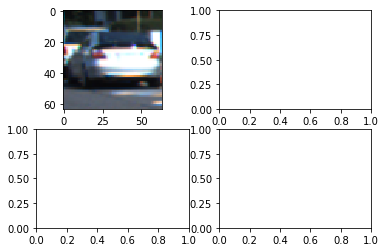

In [12]:
import skimage.feature
from cached_property import cached_property
import numpy as np
from sklearn.preprocessing import StandardScaler


class HogSettings:
    PIXELS_PER_CELL = 8
    CELLS_PER_BLOCK = 3
    PIXELS_PER_BLOCK = PIXELS_PER_CELL * CELLS_PER_BLOCK


class FeatureExtractorUnnormalized(HogSettings):

    def __init__(self, img, use_ycrcb=True):
        self.img = img
        self.use_ycrcb = use_ycrcb
    
    @cached_property
    def gray(self):
        return cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
    
    @cached_property
    def ycrcb(self):
        return cv2.cvtColor(self.img, cv2.COLOR_RGB2YCrCb)
    
    @cached_property
    def ycrcb_by_chan(self):
        # separate into channels
        # TODO there must be a better way to do this
        return np.array([self.ycrcb[:,:,0], self.ycrcb[:,:,1], self.ycrcb[:,:,2]])

    def do_hog(self, gray_img, visualise=False, feature_vector=True):
        return skimage.feature.hog(gray_img, block_norm='L2-Hys', visualise=visualise,
                                   feature_vector=feature_vector)

    @cached_property
    def hog(self):
        return self.hog_array.ravel()
    
    @cached_property
    def hog_viz(self):
        chans_viz = [self.do_hog(c, visualise=True)[1] for c in self.ycrcb_by_chan]
        print([v.shape for v in chans_viz])
        print([v.dtype for v in chans_viz])
        print([np.min(v) for v in chans_viz])
        print([np.max(v) for v in chans_viz])
        chans_viz = [cv2.cvtColor(v, cv2.COLOR_GRAY2RGB) for v in chans_viz]
        height, width = self.img.shape[:2]
        rv = np.zeros((height * 2, width * 2, 3))
        rv[:height, :width] = self.img
        rv[:height, width:] = chans_viz[0]
        rv[height:, :width] = chans_viz[1]
        rv[:height, :width] = chans_viz[2]
        return rv
    
    @cached_property
    def hog_array(self):
        if self.use_ycrcb:
            return np.array([self.do_hog(c, feature_vector=False) for c in self.ycrcb_by_chan])
        else:
            return self.do_hog(self.gray, feature_vector=False)
    
    def hog_window(self, min_block_x, min_block_y, max_block_x, max_block_y):
        # min and max are *inclusive*
        if self.use_ycrcb:
            return self.hog_array[:, min_block_y:max_block_y + 1, min_block_x:max_block_x + 1].ravel()
        else:
            return self.hog_array[min_block_y:max_block_y + 1, min_block_x:max_block_x + 1].ravel()
    
    def hog_window_viz(self, min_block_x, min_block_y, max_block_x, max_block_y):
        img = self.gray[min_block_y * self.PIXELS_PER_CELL
                        :(max_block_y + self.CELLS_PER_BLOCK) * self.PIXELS_PER_CELL,
                        min_block_x * self.PIXELS_PER_CELL
                        :(max_block_x + self.CELLS_PER_BLOCK) * self.PIXELS_PER_CELL]
        
        print(min_block_y * self.PIXELS_PER_CELL)
        print((max_block_y + self.CELLS_PER_BLOCK) * self.PIXELS_PER_CELL)
        print(min_block_x * self.PIXELS_PER_CELL)
        
        return self.do_hog(img, visualise=True)[1]
        #return img


_, axes = plt.subplots(2, 2)
axes[0][0].imshow(vehicles_train[0])
axes[0][1].imshow(FeatureExtractorUnnormalized(vehicles_train[0]).hog_viz)
axes[1][0].imshow(non_vehicles_train[0])
axes[1][1].imshow(FeatureExtractorUnnormalized(non_vehicles_train[0]).hog_viz)
print(FeatureExtractorUnnormalized(vehicles_train[0], use_ycrcb=True).hog.shape)
print(3*6*6*3*3*9)

In [ ]:
%%time
x_unn = [FeatureExtractorUnnormalized(im, use_ycrcb=True).hog for im in vehicles_train + non_vehicles_train]

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
normalizer.fit(x_unn)

In [ ]:
class FeatureExtractor(FeatureExtractorUnnormalized):
    @cached_property
    def hog(self):
        unnormed = super().hog
        normed = normalizer.transform([unnormed])[0]
        return normed
    
    def hog_window(self, min_block_x, min_block_y, max_block_x, max_block_y):
        unnormed = super().hog_window(
            min_block_x, min_block_y, max_block_x, max_block_y)
        normed = normalizer.transform([unnormed])[0]
        return normed

In [ ]:
x = [FeatureExtractor(im, use_ycrcb=True).hog for im in vehicles_train + non_vehicles_train]

In [ ]:
import pickle

def try_load_obj(name, globals_):
    if os.path.exists(f'pickled/{name}'):
        with open(f'pickled/{name}', 'rb') as f:
            globals_()[name] = pickle.load(f)
            return True
    return False

def save_obj(name, obj):
    with open(f'pickled/{name}', 'wb') as f:
        pickle.dump(obj, f)

In [ ]:
%%time
import sklearn.svm

if not try_load_obj('clf', globals):
    clf = sklearn.svm.SVC(kernel='linear')

    y = [1] * len(vehicles_train) + [0] * len(non_vehicles_train)

    clf.fit(x, y)
    
    save_obj('clf', clf)

In [ ]:
%%time
import numpy as np

x_test = [FeatureExtractor(im, use_ycrcb=True).hog for im in vehicles_test + non_vehicles_test]
y_test = np.array([1] * len(vehicles_test) + [0] * len(non_vehicles_test))

In [ ]:
%%time
yhat_test = clf.predict(x_test)

In [ ]:
acc = np.average(yhat_test == y_test)
acc_pct = acc * 100
print(f'Test accuracy: {acc_pct:.2f}%')

In [ ]:
import math

def calc_scales(min, max, num, exp=False):
    # if exp is True, does exponential scales, otherwise linear
    if exp:
        min, max = np.log([min, max])
    x = list(range(num))
    xp = [0, num - 1]
    yp = [min, max]
    rv = np.interp(x, xp, yp)
    if exp:
        rv = np.exp(rv)
    return list(map(float, rv))


class Window:
    def __init__(self, frame_processor, scale_num, min_block_x, min_block_y, max_block_x, max_block_y):
        # min and max are *inclusive*!
        # self.frame_processor = frame_processor
        self.scale_num = scale_num
        self.min_block_x = min_block_x
        self.min_block_y = min_block_y
        self.max_block_x = max_block_x
        self.max_block_y = max_block_y
        
        self.scale = frame_processor.SCALES[self.scale_num]
        
        def map_x(x):
            return int(round(x * frame_processor.PIXELS_PER_CELL * self.scale))
        
        def map_y(y):
            return map_x(y) + frame_processor.MIN_Y
        
        self.upper_left_px = (map_x(min_block_x), map_y(min_block_y))
        self.lower_right_px = (
            map_x(max_block_x) + round(frame_processor.PIXELS_PER_BLOCK * self.scale),
            map_y(max_block_y) + round(frame_processor.PIXELS_PER_BLOCK * self.scale),
        )
    
    def __iter__(self):
        return iter([self.scale_num, self.min_block_x, self.min_block_y, self.max_block_x, self.max_block_y])

    @cached_property
    def bounding_box_px(self):
        return (self.upper_left_px, self.lower_right_px)


class FrameProcessor(HogSettings):
    MIN_Y = 410
    MAX_Y = 670
    # these MIN_X and MAX_X values assume car is in the leftmost lane
    MIN_X = 562  # applies to MIN_Y row
    MAX_X = 1222 # applies to MIN_Y row
    
    MIN_SIZE = 64
    MAX_SIZE = MAX_Y - MIN_Y
    MIN_SCALE = 1
    MAX_SCALE = MAX_SIZE / MIN_SIZE
    NUM_SCALES = 5
    EXP = True
    SCALES = calc_scales(MIN_SCALE, MAX_SCALE, NUM_SCALES, exp=EXP)

    PIXELS_PER_WINDOW = 64
    WINDOW_OVERLAP_CELLS = 2
    CELLS_PER_WINDOW = PIXELS_PER_WINDOW // HogSettings.PIXELS_PER_CELL

    def __init__(self, img_or_path):
        if isinstance(img_or_path, str):
            self.img = cv2.cvtColor(cv2.imread(img_or_path), cv2.COLOR_BGR2RGB)
        else:
            self.img = img_or_path
    
    @cached_property
    def windows_old(self):
        # returns tuples of (scale_num, min_block_x, min_block_y, max_block_x, max_block_y)
        # assumes we're indexing into a scaled version of the cropped image
        rv = []
        for scale_num in range(self.NUM_SCALES):
            scale = self.SCALES[scale_num]
            width = self.img.shape[1] // scale
            height = (self.MAX_Y - self.MIN_Y) // scale
            
            window_step = self.PIXELS_PER_CELL * self.WINDOW_OVERLAP_CELLS
            windows_x = int((width - self.PIXELS_PER_WINDOW) // window_step + 1)
            windows_y = int((height - self.PIXELS_PER_WINDOW) // window_step + 1)
            
            for wx in range(windows_x):
                for wy in range(windows_y):
                    rv.append(Window(
                        self,
                        scale_num,
                        wx * self.WINDOW_OVERLAP_CELLS,
                        wy * self.WINDOW_OVERLAP_CELLS,
                        wx * self.WINDOW_OVERLAP_CELLS + self.CELLS_PER_WINDOW - self.CELLS_PER_BLOCK,
                        wy * self.WINDOW_OVERLAP_CELLS + self.CELLS_PER_WINDOW - self.CELLS_PER_BLOCK,
                    ))
        
        return rv
    
    @cached_property
    def windows(self):
        # some really hacky optimizations
        rv = []
        for w in self.windows_old:
            # remove windows in the upper left of the image
            lower_right = w.bounding_box_px[1]
            x, y = lower_right
            if y < 681 + (476 - 681) / (582 - 284) * (x - 284):
                continue
            
            # remove too-small windows in lower area of image
            expected_scale = (y - self.MIN_Y) / (self.MAX_Y - self.MIN_Y) * self.SCALES[-1]
            if w.scale < expected_scale - 0.5:
                continue
                
            rv.append(w)

        return rv
    
    def viz_for_window(self, idx):
        rv = np.copy(self.img)
        w = self.windows[idx]
        cv2.rectangle(
            rv,
            *w.bounding_box_px,
            (0, 0, 255),
            thickness=5,
        )
        return rv

    @cached_property
    def windows_viz(self):
        r = random.Random(44)
        rv = np.copy(self.img)
        for w in self.windows:
            if r.random() < 0.9:
                continue

            cv2.rectangle(
                rv,
                *w.bounding_box_px,
                (0, 0, 255),
                thickness=5,
            )

        return rv
    
#     @cached_property
#     def windows_viz_multi(self):
#         rv = np.zeros([self.NUM_SCALES, 4, 720, 1280, 3])
#         for scale_num in range(self.NUM_SCALES):
#             for i in range(4):
#                 img = rv[scale_num][i] = 

fp = FrameProcessor('test_images/test1.jpg')

plt.figure(figsize=(20,10))
plt.imshow(fp.windows_viz)
# plt.imshow(fp.viz_for_window(257))
# _, axes = plt.subplots(10, figsize=(50, 50))
# for idx in range(10):
#     # ax = axes[idx // 2][idx % 2]
#     ax = axes[idx]
#     ax.imshow(fp.viz_for_window(idx))

print(FrameProcessor.SCALES)
print(fp.MIN_Y)

In [ ]:
class FrameProcessor2(FrameProcessor):  # bad name, 🤷 ¯\_(ツ)_/¯ 🤷
    @cached_property
    def roi(self):
        return self.img[self.MIN_Y:self.MAX_Y, :]

    @cached_property
    def scaled_rois(self):
        rv = []
        for i, scale in enumerate(self.SCALES):
            width = round(self.roi.shape[1] / scale)
            height = round(self.roi.shape[0] / scale)
            rv.append(cv2.resize(self.roi, (width, height)))
        return rv
    
    @cached_property
    def feature_extractors_per_scale(self):
        return [FeatureExtractor(self.scaled_rois[i]) for i in range(self.NUM_SCALES)]
    
    @cached_property
    def windows_with_cars(self):
        rv = []
        for w in self.windows:
            scale_num, min_block_x, min_block_y, max_block_x, max_block_y = w
            feat = self.feature_extractors_per_scale[scale_num].hog_window(
                min_block_x, min_block_y, max_block_x, max_block_y)
            if clf.predict([feat])[0]:
                rv.append(w)
        
        return rv
    
    @cached_property
    def windows_with_cars_viz(self):
        rv = np.copy(self.img)
        for w in self.windows_with_cars:
            cv2.rectangle(
                rv,
                *w.bounding_box_px,
                (0, 0, 255),
                thickness=5,
            )

        return rv
    
    def hog_viz_for_window(self, idx):
        scale_num, min_block_x, min_block_y, max_block_x, max_block_y = self.windows[idx]
        return self.feature_extractors_per_scale[scale_num].hog_window_viz(
            min_block_x, min_block_y, max_block_x, max_block_y
        )

fp = FrameProcessor2('test_images/test1.jpg')
plt.figure(figsize=(10, 20))
#plt.imshow(fp.hog_viz_for_window(257))
plt.imshow(fp.windows_with_cars_viz)

In [ ]:
class FrameProcessor3(FrameProcessor2):
    THRESHOLD = 5

    @cached_property
    def heatmap(self):
        rv = np.zeros(self.img.shape[:-1], dtype=np.uint32)
        for w in self.windows_with_cars:
            bbox = w.bounding_box_px
            rv[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
        
        return rv
    
    @cached_property
    def heatmap_threshold(self):
        return (self.heatmap >= self.THRESHOLD).astype(np.uint8)

    @cached_property
    def heatmap_viz(self):
        return (self.heatmap * 255 // np.max(self.heatmap)).astype(np.uint8)
    


fp = FrameProcessor3('test_images/test1.jpg')
print(np.max(fp.heatmap))
plt.imshow(fp.heatmap_threshold)

In [ ]:
%%time
# this cell used for debugging, can be deleted
heatmap_frames = []

cap = cv2.VideoCapture('test_video.mp4')
for i in range(10):
    ret, frame = cap.read()
    hm = FrameProcessor3(frame).heatmap
    heatmap_frames.append(hm)


In [ ]:
%%time
import glob
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label


class MultiFrameHeatmapProcessor:
    def __init__(self, frame_heatmaps):
        self.frame_heatmaps = frame_heatmaps
    
    @cached_property
    def sum_heatmaps(self):
        return np.sum(self.frame_heatmaps, axis=0)
    
    @cached_property
    def sum_heatmaps_viz(self):
        if np.max(self.sum_heatmaps) == 0:
            rv = self.sum_heatmaps.astype(np.uint8)
        else:
            rv = (self.sum_heatmaps * 255 // np.max(self.sum_heatmaps)).astype(np.uint8)
        return cv2.cvtColor(rv, cv2.COLOR_GRAY2RGB)
    
    @cached_property
    def thresh(self):
        return (self.sum_heatmaps >= FrameProcessor3.THRESHOLD * len(self.frame_heatmaps)).astype(np.uint8)
    
    @cached_property
    def thresh_viz(self):
        return cv2.cvtColor(self.thresh.astype(np.uint8) * 255, cv2.COLOR_GRAY2RGB)
    
    @cached_property
    def closed(self):
        # this helps eliminate small islands near main bounding boxes that would be identified as distinct cars
        return cv2.morphologyEx(self.thresh, cv2.MORPH_CLOSE, np.ones((9, 9), dtype=np.uint8))
    
    @cached_property
    def closed_viz(self):
        return cv2.cvtColor(self.closed.astype(np.uint8) * 255, cv2.COLOR_GRAY2RGB)
    
    @cached_property
    def car_bboxes(self):
        labeled, n_cars = label(self.closed)
        
        rv = []
        for n in range(1, n_cars + 1):
            nonzero = (labeled == n).nonzero()
            bbox = (
                (
                    np.min(nonzero[1]),
                    np.min(nonzero[0]),
                ),
                (
                    np.max(nonzero[1]),
                    np.max(nonzero[0]),
                ),
            )
            rv.append(bbox)
        
        return rv
    
    @cached_property
    def car_bboxes_viz(self):
        rv = np.zeros(self.sum_heatmaps.shape + (3,), dtype=np.uint8)
        
        for bbox in self.car_bboxes:
            cv2.rectangle(
                rv,
                *bbox,
                (0, 0, 255),
                thickness=5,
            )
        
        return rv


class CumulativeFrameProcessor:
    FRAME_WINDOW = 10

    def __init__(self):
        self.heatmaps_buffer = []
        self.frame_num = -1

    def process_frame(self, frame, viz='car_bboxes_viz'):
        self.frame_num += 1
        
        hm = FrameProcessor3(frame).heatmap
        self.heatmaps_buffer.append(hm)
        
        if len(self.heatmaps_buffer) < self.FRAME_WINDOW:
            viz = np.zeros_like(frame)
        else:
            viz = MultiFrameHeatmapProcessor(self.heatmaps_buffer).car_bboxes_viz
            del self.heatmaps_buffer[0]
    
        rv = np.copy(frame)
        viz_mask = np.any(viz, axis=-1)
        rv[viz_mask] = 0
        rv += viz

        cv2.imwrite(f'frames/{self.frame_num:05}.jpg', cv2.cvtColor(rv, cv2.COLOR_RGB2BGR))    
        
        return rv
    
    def process_frame_heatmap_viz(self, frame):
        rv = self.process_frame(frame)
        if np.max(rv) == 0:
            rv = rv.astype(np.uint8)
        else:
            rv = (rv * 255 // np.max(rv)).astype(np.uint8)
        rv = cv2.cvtColor(rv, cv2.COLOR_GRAY2RGB)
        return rv
    
    def process_frame_threshold_viz(self, frame):
        rv = self.process_frame(frame)
        rv = ((rv >= self.THRESHOLD) * 255).astype(np.uint8)
        rv = cv2.cvtColor(rv, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(f'frames/{self.frame_num:05}.jpg', rv)
        return rv
    

def process_video(inpath, outpath):
    for path in glob.glob('frames/*'):
        os.unlink(path)
    
    inclip = VideoFileClip(inpath)
    proc = CumulativeFrameProcessor()
    
    outclip = inclip.fl_image(proc.process_frame)
    
    outclip.write_videofile(outpath, audio=False)


process_video('cropped_project_vid.mp4', 'outvid.mp4')
# mfhp = MultiFrameHeatmapProcessor(heatmap_frames)
# print(mfhp.sum_heatmaps.dtype)
# plt.imshow(MultiFrameHeatmapProcessor(heatmap_frames).car_bboxes_viz)
